In [2]:
!pip install networkx --user
import numpy as np
import networkx as nx
print("Networkx version: {}".format(nx.__version__))
from time import time
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set()

%matplotlib inline

You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Networkx version: 2.3


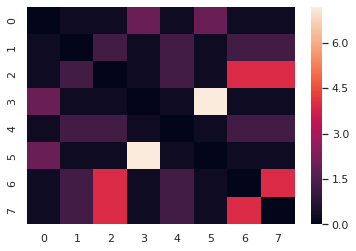

In [5]:
G = nx.read_edgelist("data/resnik.txt", delimiter='\t' , nodetype=str,  data=(('weight',float),))
G0 = G.subgraph(['ACD', 'ABL1', 'ACTL6A', 'ACTR5', 'ACTR8', 'ALKBH1', 'ALKBH2', 'ALKBH3'])
A = nx.adjacency_matrix(G0)
ax = sns.heatmap(A.todense())

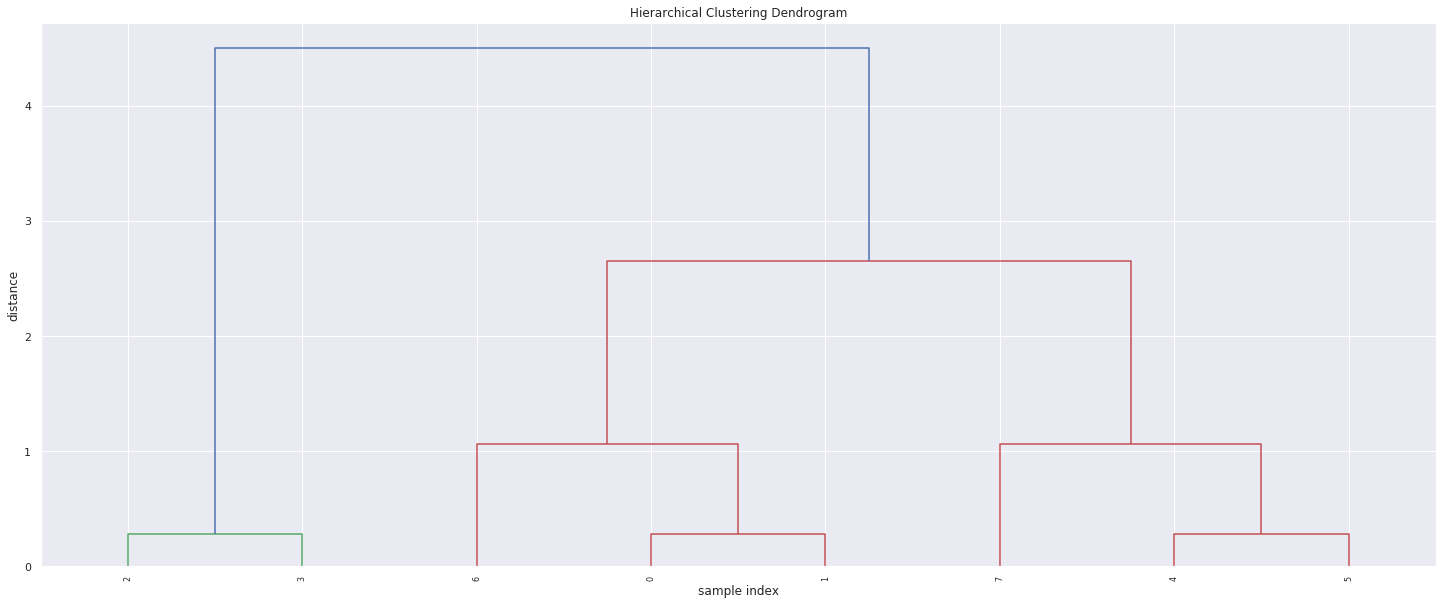

array([[ 0.        ,  1.        ,  0.27963638,  2.        ],
       [ 2.        ,  3.        ,  0.27963638,  2.        ],
       [ 4.        ,  5.        ,  0.27963638,  2.        ],
       [ 6.        ,  8.        ,  1.05721886,  3.        ],
       [ 7.        , 10.        ,  1.05721886,  3.        ],
       [11.        , 12.        ,  2.65267159,  6.        ],
       [ 9.        , 13.        ,  4.49761348,  8.        ]])

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

listA = squareform(A.todense())
Z = linkage(listA, 'ward')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()
Z

In [111]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# Construct the graph/hierarchy
d           = { 2: [0, 1], 0: ['c', 'd','e'], 1: ['a', 'b'], 'a': [], 'b': [], 'c': [], 'd': [], 'e': []}
G           = nx.DiGraph(d)
nodes       = G.nodes()
leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(d[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += d[v]
    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last
subtree

{'c': ['c'],
 'a': ['a'],
 'e': ['e'],
 'b': ['b'],
 'd': ['d'],
 2: ['a', 'b', 'c', 'd', 'e'],
 0: ['c', 'd', 'e'],
 1: ['a', 'b']}

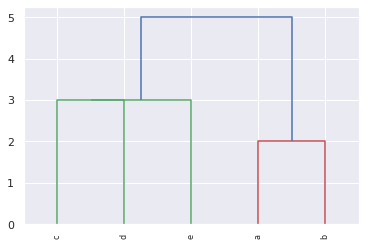

In [126]:
# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z0 = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = d[n]
    if children:
        x = children[0]
        for y in children[1:]:
            z = tuple(sorted(subtree[x] + subtree[y]))
            #print(y)
            u, v = index[tuple(subtree[x])], index[tuple(subtree[y])]            
            dist = float(len(subtree[n]))
            Z0.append([u, v, dist, len(z)]) # <-- float is required by the dendrogram function
            index[z] = k
            subtree[z] = sorted(z)
            x = z
            k += 1
# Visualize
if Z0:
    dendrogram(
    Z0,
    labels=leaves,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    )
    plt.show()

In [122]:
GU = nx.to_undirected(G)
T = nx.minimum_spanning_tree(GU)

In [4]:
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
leaves

NameError: name 'leaves' is not defined

In [5]:
for i, n in enumerate(leaves):
    print(i,n)

NameError: name 'leaves' is not defined

In [7]:
nx.is_directed(G0)

False

In [8]:
import pymc3 as pm
import theano.tensor as tt

def make_pymc3_sbm(Gs, k, labels, weighted=True, directed=False, selfloops=False):
    # input can be a single graph or a list of graphs
    if isinstance(Gs, nx.Graph):
        Gs = [Gs]
    n = len(Gs[0])
    # whether to include the diagonal or not
    if selfloops:
        triu_indices = np.triu_indices(n, k=1)
    else:
        triu_indices = np.triu_indices(n)
    # convert to adjacency matrix
    # if graph is undirected, we just need the upper triangular part
    if directed:
        A_obs = np.array([nx.to_numpy_array(G) for G in Gs])
    else:
        A_obs = np.array([nx.to_numpy_array(G)[triu_indices] for G in Gs])

    model = pm.Model()
    with model:
        #pi = pm.Dirichlet('pi', a=np.ones(k), shape=(k,))
        z = labels #pm.Categorical('z', p=pi, shape=(n,))
        if weighted:
            eta = pm.Normal('eta', mu=10, sd = 1, shape=(k, k))
        else:
            eta = pm.Beta('eta', alpha=1, beta=1, shape=(k, k))
        # parameters to sample the adjacency matrix
        # p[i, j] = eta[z[i], z[j]] is the parameter corresponding to A[i, j]
        p = eta[(z.reshape((n, 1)), z.reshape((1, n)))]
        if not selfloops:
            tt.set_subtensor(p[np.diag_indices(n)], 0.)
        if not directed:
            p = eta[(z.reshape((n, 1)), z.reshape((1, n)))][triu_indices]
        if weighted:
            W = pm.Normal('W', mu=p, sd=1, shape=A_obs[0].shape, observed=A_obs)
        else:
            W = pm.Bernoulli('W', p=p, shape=A_obs[0].shape, observed=A_obs)
    return model

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


In [16]:
np.arange(0,8,1)

array([0, 1, 2, 3, 4, 5, 6, 7])

/home/jovyan/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


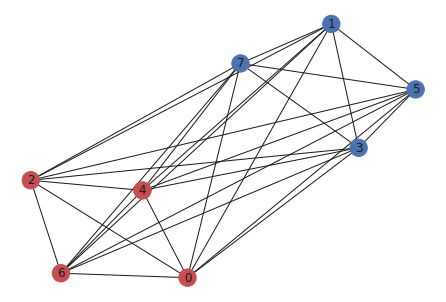

In [5]:
import networkx as nx

# let's generate some data
# there are 2 communities (even and odd nodes)
# intra community edge probability is 0.8
# inter community edge probability is 0.1
Gs = []
p = 100
q = 10
t = 1
n = 8
for i in range(t):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i + 1, n):
            theta = p if (i % 2 == j % 2) else q
            G.add_edge(i, j, weight= np.random.normal(theta, 1, 1))
    Gs.append(G)
    
# show first 5 graphs
pos = nx.spring_layout(Gs[0])
colors = np.array(['r', 'b'])
ground_truth = np.array([i % 2 for i in range(n)])
for i in range(t):
    G = Gs[i]
    nx.draw(G, node_color=colors[ground_truth], with_labels=True, pos=pos)
    plt.show()
    plt.close()

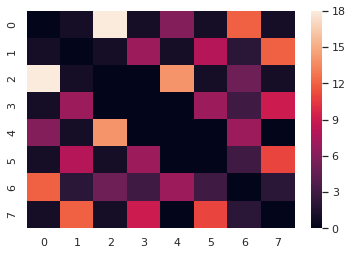

In [79]:
A0 = nx.adjacency_matrix(Gs[0])
ax = sns.heatmap(A0.todense())

In [44]:
k = 8
labels = np.arange(0,8,1)
model = make_pymc3_sbm(G0, k, labels)
with model as m1:
    #start = pm.find_MAP()
    #trace = pm.sample(50000, start=start, progressbar=True)
    trace1 = pm.sample(200, tune = 500)

/home/jovyan/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/jovyan/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 2100/2100 [00:03<00:00, 

In [26]:
k = 7
labels2 = np.array([0, 1, 2, 3, 4, 5, 5, 6])
model = make_pymc3_sbm(G0, k, labels2)
with model as m2b:
    #start = pm.find_MAP()
    #trace = pm.sample(50000, start=start, progressbar=True)
    trace2b = pm.sample(500, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 3000/3000 [00:03<00:00, 815.96draws/s]


In [110]:
A = nx.adjacency_matrix(G0).todense()
np.argmax(np.max(A, axis=1))

3

In [108]:
np.argmax(np.max(A, axis=0))

3

In [ ]:
def getCandidates(G, k, labels, thresh):
    A = nx.adjacency_matrix(G)
    listA = squareform(A.todense())
    Z = linkage(listA, 'ward')

In [94]:
def buildLayer(G, k, Llist):
    Mlist = []
    Tlist = []

    for iteration in range (0,3):
        labels = Llist[iteration]
        model = make_pymc3_sbm(G, k, labels)
        with model as modelX:
            trace = pm.sample(200, tune = 500)
        Mlist.append(modelX)
        Tlist.append(trace)

    Mlist[0].name = '0'
    Mlist[1].name = '1'
    Mlist[2].name = '2'
    comp = pm.compare({Mlist[0]: Tlist[0], Mlist[1]: Tlist[1], Mlist[2]: Tlist[2]}, method='BB-pseudo-BMA')
    print(comp.weight)
    return comp.weight

In [81]:
Llist = []
Llist.append(np.array([0, 1, 2, 3, 4, 5, 6, 0]))
Llist.append(np.array([0, 1, 2, 3, 4, 5, 5, 6]))
Llist.append(np.array([0, 1, 2, 3, 4, 5, 6, 6]))

ModelPosterior = buildLayer(G0, 7, Llist)
thresh = 0.03
newInternal = ModelPosterior[ModelPosterior  > thresh].index.astype(int)


/home/jovyan/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/jovyan/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 2100/2100 [00:02<00:00, 

2    0.71
1    0.29
0       0
Name: weight, dtype: object


Index(['2', '1'], dtype='object')

In [93]:
Llist[ModelPosterior[ModelPosterior  > thresh].index.astype(int)[0]]

array([0, 1, 2, 3, 4, 5, 6, 6])

In [82]:
ModelPosterior

2    0.71
1    0.29
0       0
Name: weight, dtype: object

In [36]:
pm.summary(Tlist[1])
pm.traceplot(Tlist[0])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
eta__0_0,4.984746,0.708352,0.011246,3.606535,6.367275,4151.496002,1.000770
eta__0_1,5.127139,0.687079,0.011744,3.611550,6.376318,3750.895834,0.999041
eta__0_2,5.149377,0.693570,0.009934,3.784594,6.454971,3956.699252,0.999311
eta__0_3,5.949188,0.703688,0.013567,4.589556,7.409916,3256.128978,0.999652
eta__0_4,5.151541,0.727295,0.014109,3.663849,6.489272,3327.325141,0.999412
eta__0_5,4.060299,0.577920,0.009777,3.077110,5.300097,3627.227299,0.999663
eta__0_6,5.145547,0.730219,0.011638,3.725907,6.530814,5520.147340,0.999004
eta__1_0,9.988943,0.991510,0.014967,8.084959,11.933439,4724.802047,0.999599
eta__1_1,4.984978,0.693128,0.012958,3.588580,6.242537,3122.322578,0.999155
eta__1_2,5.632044,0.693495,0.012783,4.285253,7.032856,3329.386844,0.999059


/home/jovyan/.local/lib/python3.7/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.


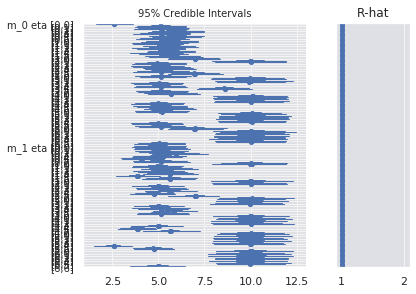

In [37]:
from pymc3 import forestplot, traceplot, plot_posterior
#traces = [trace1, trace2]
pm.forestplot(Tlist);

In [28]:
Mlist[0].name = 'k=7'
Mlist[1].name = 'k=7b'
comp = pm.compare({m1: trace1, m2: trace2, m2b: trace2b}, method='BB-pseudo-BMA')
comp

/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
k=7b,1063.97,282.39,0,0.96,85.11,0,1
k=7,1234.07,343.99,170.1,0.04,69.34,94.38,1
k=8,1336.76,376.91,272.79,0,54.9,69.26,1


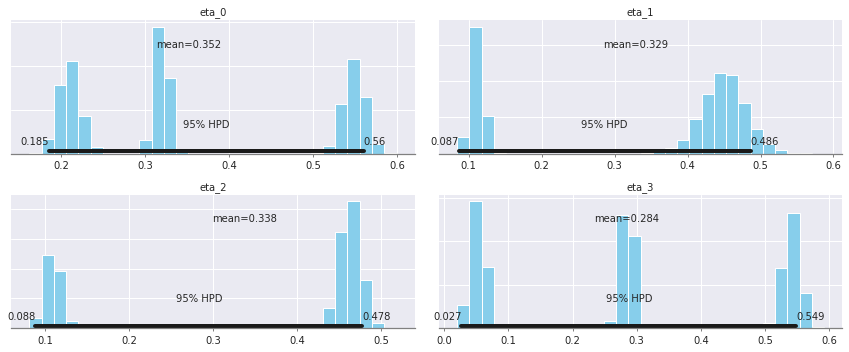

In [87]:
pm.plot_posterior(trace, varnames=['eta']);

In [31]:
weights = comp.weight.sort_index(ascending=True)
weights

k=7     0.04
k=7b    0.96
k=8        0
Name: weight, dtype: object

In [33]:
thresh = 0.3
threshold_indices = weights > thresh
weights[threshold_indices]

k=7b    0.96
Name: weight, dtype: object

In [34]:
for iteration in range (0,2):
    print(iteration)

0
1
